In [1]:
import re
import os
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.utils import shuffle
from sklearn.datasets import fetch_20newsgroups


%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
newsgroups_train = fetch_20newsgroups(
    subset="train", remove=("headers", "footers", "quotes")
)

<IPython.core.display.Javascript object>

In [3]:
ng_df = pd.DataFrame(newsgroups_train.data, columns=["content"])
ng_df["target"] = pd.Series(newsgroups_train.target, index=ng_df.index)

<IPython.core.display.Javascript object>

In [4]:
# Load classifier
classifier = pipeline("zero-shot-classification", model="roberta-large-mnli")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at roberta-large-mnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


<IPython.core.display.Javascript object>

In [5]:
categories = [
    "atheism",
    "computer graphics",
    "microsoft windows",
    "pc hardware",
    "apple hardware",
    "x window system",
    "for sale",
    "autos",
    "motorcycles",
    "baseball",
    "hockey",
    "cryptography",
    "electronics",
    "medicine",
    "space",
    "christianity",
    "politics guns",
    "politics middle east",
    "politics",
    "religion",
]
content_re = "(\\n)|\\|(\-{2,}.*)|(\\t)|[\(\)\[\]\*\@\#\/\<\>\_\-\^\{\}]"

cat_simp_map = [
    "religion",
    "computer hardware",
    "computer software",
    "computer hardware",
    "computer hardware",
    "computer software",
    "for sale",
    "cars",
    "motorcycles",
    "baseball",
    "hockey",
    "cryptography",
    "electronics",
    "medicine",
    "atronomy or outer space",
    "religion",
    "guns",
    "the middle east",
    "politics",
    "religion",
]

<IPython.core.display.Javascript object>

In [6]:
ng_df["content"] = (
    ng_df["content"]
    .apply(lambda x: re.sub(content_re, " ", x))
    .apply(lambda x: re.sub("\s{2,}", " ", x))
)
ng_df["target"] = ng_df["target"].apply(lambda x: cat_simp_map[x])
ng_df["con_len"] = ng_df["content"].apply(lambda x: len(x) if x != None else 0)

<IPython.core.display.Javascript object>

In [8]:
ng_df.to_pickle("C:/Users/rparg/Documents/Data/newsgroups/ng_super_cat.pkl")

<IPython.core.display.Javascript object>

In [9]:
ng_df = pd.read_pickle("C:/Users/rparg/Documents/Data/newsgroups/ng_super_cat.pkl")

<IPython.core.display.Javascript object>

In [18]:
ng_sample_df = ng_df[(ng_df["con_len"] > 100) & (ng_df["con_len"] < 1000)]
ng_sample_df = shuffle(
    ng_sample_df.groupby("target")
    .apply(lambda x: x.sample(20, replace=True))
    .reset_index(drop=True)
    .drop_duplicates()
)
content_list = list(ng_sample_df["content"])
target_list = list(ng_df["target"].unique())
ng_sample_df.to_pickle("C:/Users/rparg/Documents/Data/newsgroups/ng_super_sample.pkl")

<IPython.core.display.Javascript object>

In [72]:
ng_sample_df = pd.read_pickle(
    "C:/Users/rparg/Documents/Data/newsgroups/ng_super_sample.pkl"
)

<IPython.core.display.Javascript object>

In [23]:
class_list = [
    classifier(content, target_list, multi_label=True) for content in content_list
]
ng_clfd_df = pd.DataFrame.from_records(class_list)
ng_clfd_df["predicted"] = ng_clfd_df["labels"].apply(lambda x: x[0])
ng_clfd_df["high_score"] = ng_clfd_df["scores"].apply(lambda x: x[0])
ng_clfd_df = ng_clfd_df.rename(
    {"sequence": "content"},
    axis=1,
)
ng_super_sample_clfd_df = ng_sample_df.merge(ng_clfd_df, how="inner", on="content")
ng_super_sample_clfd_df.to_pickle(
    "C:/Users/rparg/Documents/Data/newsgroups/ng_super_sample_clfd.pkl"
)

<IPython.core.display.Javascript object>

In [22]:
ng_super_sample_clfd_df

,content,target,con_len,labels,scores,predicted,high_score
0,"Hi there, I can't seem to get mail to you. Can...",hockey,165,"[the middle east, computer software, for sale,...","[0.2192583680152893, 0.18975695967674255, 0.15...",the middle east,0.219258
1,"Yes, eXceed has windows version. Have ported ...",computer software,225,"[computer software, for sale, cars, computer h...","[0.9744587540626526, 0.5807973742485046, 0.317...",computer software,0.974459


<IPython.core.display.Javascript object>

In [ ]:
# Read results

In [24]:
results_df = pd.read_pickle(
    "C:/Users/rparg/Documents/Data/newsgroups/ng_super_sample_clfd.pkl"
)

<IPython.core.display.Javascript object>

In [25]:
results_df

,content,target,con_len,labels,scores,predicted,high_score
0,"Hi there, I can't seem to get mail to you. Can...",hockey,165,"[the middle east, computer software, for sale,...","[0.2192583680152893, 0.18975695967674255, 0.15...",the middle east,0.219258
1,"Yes, eXceed has windows version. Have ported ...",computer software,225,"[computer software, for sale, cars, computer h...","[0.9744587540626526, 0.5807973742485046, 0.317...",computer software,0.974459
2,"Yea, it turned out that Gramm Rudman was a sh...",politics,644,"[politics, cryptography, electronics, for sale...","[0.7696904540061951, 0.45533066987991333, 0.29...",politics,0.769690
3,Mr. Bettman The Guy in the Wrong Sport Mr. St...,hockey,804,"[cryptography, hockey, baseball, for sale, gun...","[0.6338838338851929, 0.5783821940422058, 0.292...",cryptography,0.633884
4,"Even if it were a capital offense, the warran...",guns,249,"[guns, the middle east, for sale, motorcycles,...","[0.7006071209907532, 0.05453383922576904, 0.02...",guns,0.700607
...,...,...,...,...,...,...,...
289,"I thought it was: ""There are two kinds of peo...",motorcycles,403,"[for sale, politics, motorcycles, computer sof...","[0.41137853264808655, 0.050613436847925186, 0....",for sale,0.411379
290,"Now, that Clinton can get e mail, i'm wonderin...",politics,245,"[politics, computer software, electronics, the...","[0.7683619856834412, 0.4160480499267578, 0.228...",politics,0.768362
291,The dead giveaway is the repeated protestation...,cryptography,359,"[guns, politics, for sale, the middle east, cr...","[0.8275811076164246, 0.7038613557815552, 0.241...",guns,0.827581
292,Is there anyone out there in NetLand that has ...,cars,386,"[computer hardware, computer software, electro...","[0.6945748329162598, 0.6837870478630066, 0.436...",computer hardware,0.694575


<IPython.core.display.Javascript object>

In [26]:
y_target = np.array(results_df["target"])
y_pred = np.array(results_df["predicted"])

cm = sklearn.metrics.confusion_matrix(y_target, y_pred)
cmn = ((cm.astype("float") / cm.sum(axis=1)[:, np.newaxis])).round(decimals=3)

print(
    sklearn.metrics.classification_report(
        y_true=y_target,
        y_pred=y_pred,
        zero_division=1,
    )
)

                         precision    recall  f1-score   support

atronomy or outer space       1.00      0.40      0.57        20
               baseball       0.92      0.60      0.73        20
                   cars       0.57      0.60      0.59        20
      computer hardware       0.45      0.50      0.48        20
      computer software       0.52      0.84      0.64        19
           cryptography       0.16      0.25      0.19        20
            electronics       0.40      0.30      0.34        20
               for sale       0.34      0.84      0.48        19
                   guns       0.60      0.47      0.53        19
                 hockey       0.92      0.55      0.69        20
               medicine       1.00      0.47      0.64        19
            motorcycles       0.47      0.35      0.40        20
               politics       0.36      0.40      0.38        20
               religion       0.71      0.53      0.61        19
        the middle east 

<IPython.core.display.Javascript object>

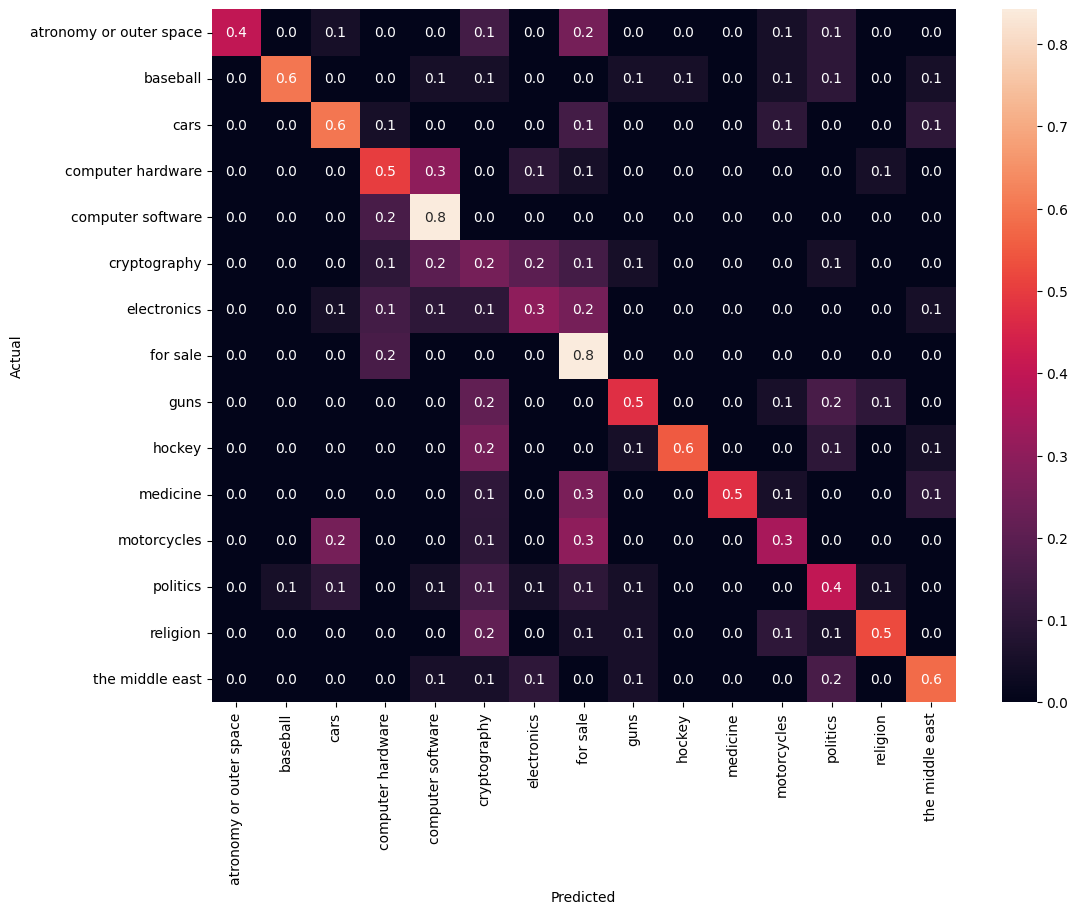

<IPython.core.display.Javascript object>

In [27]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    cmn,
    ax=ax,
    annot=True,
    fmt=".01f",
    xticklabels=np.unique(y_target),
    yticklabels=np.unique(y_pred),
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show(block=False)
plt.show()

In [60]:
results_df[results_df["target"] == "space"]["content"].values.tolist()

["        This isn't inherently bad.  This isn't really light pollution since it will only be visible shortly before or after dusk  or during the day .   Of course, if night only lasts 2 hours for you, you're probably going to be inconvienenced. But you're inconvienenced anyway in that case .  Finally: this isn't the Bronze Age, and most of us aren't Indo European; those people speaking Indo-Eurpoean languages often have much non-indo-european ancestry and cultural background. So: please try to remember that there are more human activities than those practiced by the Warrior Caste, the Farming Caste, and the Priesthood.  And why act distressed that someone's found a way to do research that doesn't involve socialism?  It certianly doesn't mean we deserve to die.",
 "   They have a few problems. The biggest technical problem is the need to find two satellites going to the same rough orbit for a luanch.  They also don't show much interest in commercial launches. There is more money to be 

<IPython.core.display.Javascript object>

In [40]:
results_df[results_df["target"] == "religion"]

,content,target,con_len,predicted,score
35,": : Nut or not, he was clearly a liar. He ...",religion,209,politics,0.840676
45,"Dennis, I'm astounded. I didn't know you were...",religion,126,for sale,0.190846
47,"John Berryhill, Ph.D. writes umm, please don...",religion,207,christianity,0.377686
62,"Yes, this is certainly one of the traditiona...",religion,536,for sale,0.547040
85,Christian anti-Semitism comes from the obviou...,religion,209,religion,0.704521
95,I suppose these illegal guns have been found?...,religion,117,guns,0.995975
115,Mr. Clinton said today that the horrible trage...,religion,403,christianity,0.995211
148,"You could argue that if you wanted, but I thin...",religion,585,religion,0.735926
169,"Sorry, the San Jose based Rosicrucian order is...",religion,470,religion,0.828335
176,Speaking as one who knows relativity and qua...,religion,252,politics,0.139541


<IPython.core.display.Javascript object>